In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
data.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [ ]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
cat_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
label_encoder = LabelEncoder()

for feature in cat_features:
    data[feature] = label_encoder.fit_transform(data[feature])

data[cat_features]

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,1,1,1,0,2
1,0,2,1,0,1
2,1,1,2,0,2
3,0,0,1,1,1
4,1,2,1,0,2
...,...,...,...,...,...
913,1,3,1,0,1
914,1,0,1,0,1
915,1,0,1,1,1
916,0,1,0,0,1


In [ ]:
X = data.drop(columns = ['HeartDisease'])
y = data["HeartDisease"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


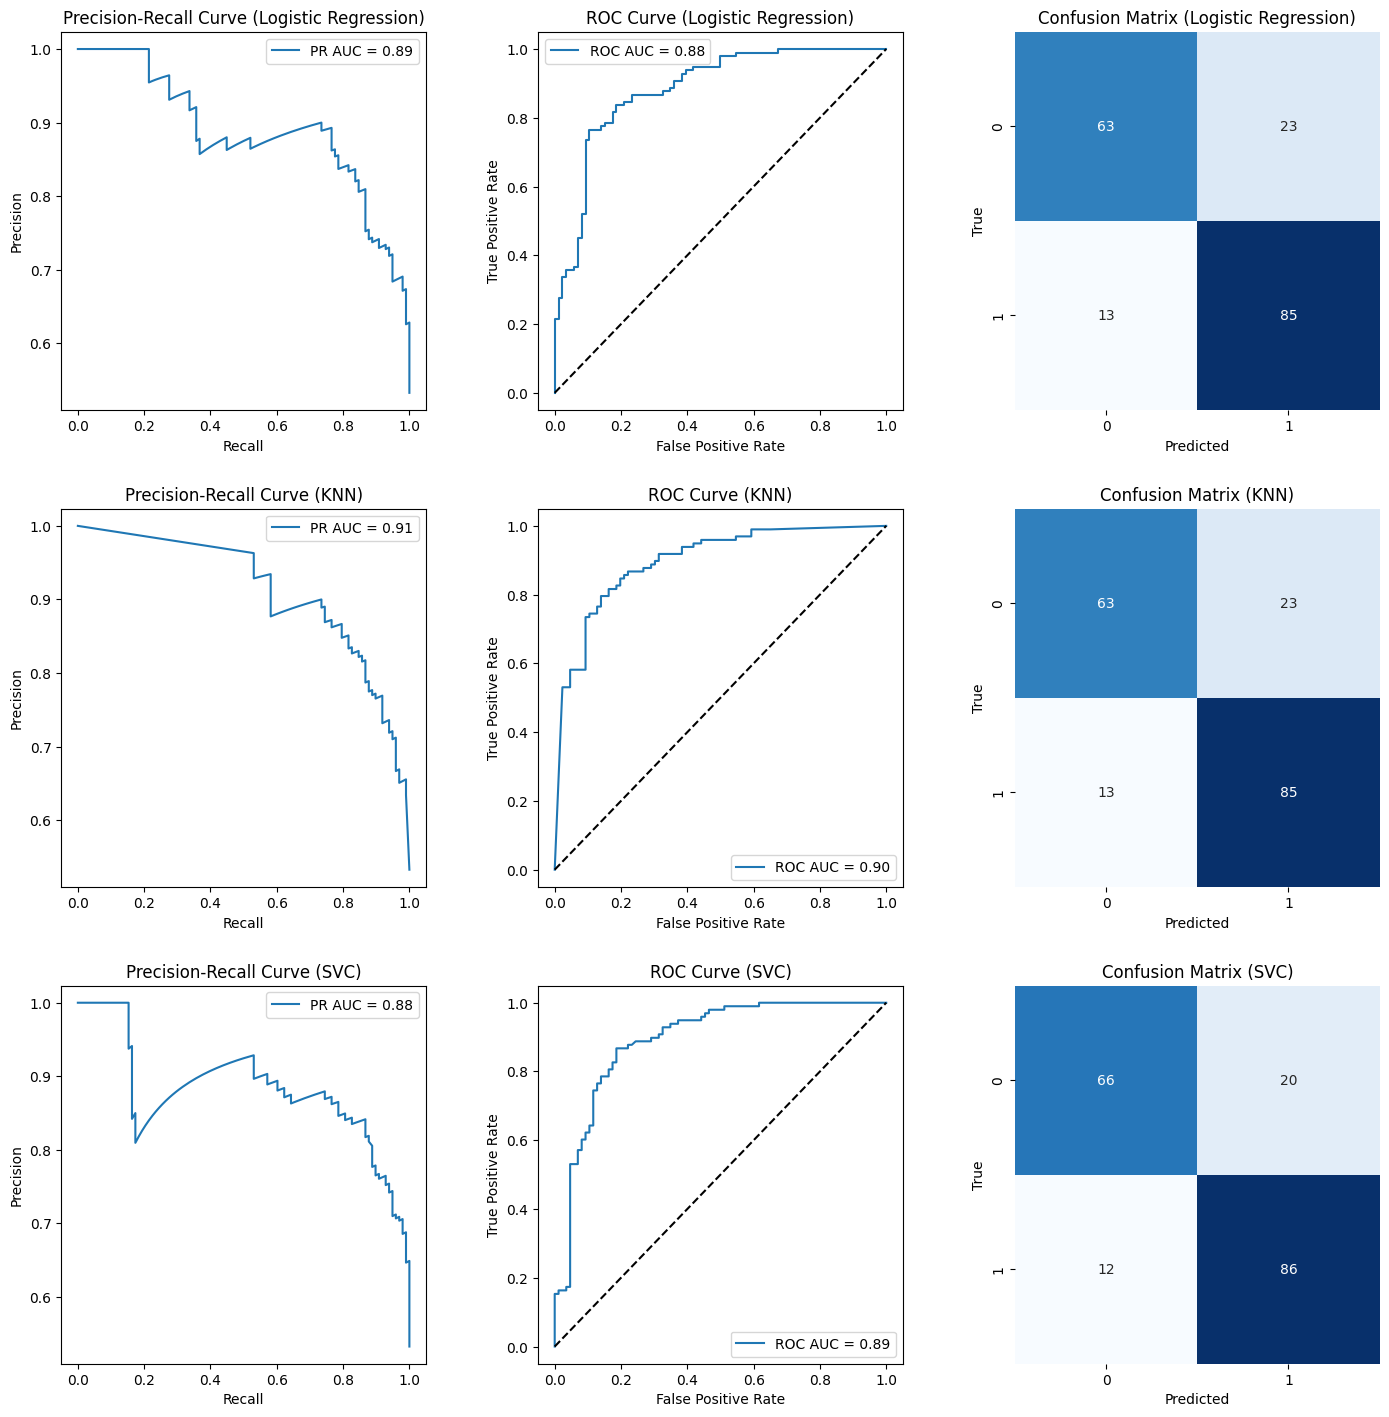

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Определение моделей и параметров для GridSearchCV
models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    'SVC': (SVC(probability=True), {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    })
}

results = {}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout(pad=5.0)

for idx, (name, (model, params)) in enumerate(models.items()):
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_f1_idx = np.argmax(f1_scores)
    optimal_f1_threshold = thresholds_pr[optimal_f1_idx]

    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    g_means = np.sqrt(tpr * (1 - fpr))
    optimal_g_mean_idx = np.argmax(g_means)
    optimal_g_mean_threshold = thresholds_roc[optimal_g_mean_idx]

    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Confusion Matrix': cm,
        'PR AUC': pr_auc,
        'ROC AUC': roc_auc,
        'Optimal F1 Threshold': optimal_f1_threshold,
        'Optimal G-Mean Threshold': optimal_g_mean_threshold
    }


    axes[idx, 0].plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    axes[idx, 0].set_xlabel('Recall')
    axes[idx, 0].set_ylabel('Precision')
    axes[idx, 0].set_title(f'Precision-Recall Curve ({name})')
    axes[idx, 0].legend()

    axes[idx, 1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    axes[idx, 1].plot([0, 1], [0, 1], 'k--')
    axes[idx, 1].set_xlabel('False Positive Rate')
    axes[idx, 1].set_ylabel('True Positive Rate')
    axes[idx, 1].set_title(f'ROC Curve ({name})')
    axes[idx, 1].legend()

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx, 2])
    axes[idx, 2].set_xlabel('Predicted')
    axes[idx, 2].set_ylabel('True')
    axes[idx, 2].set_title(f'Confusion Matrix ({name})')

plt.show()


In [ ]:
for name, (model, _) in models.items():
    print(f"\nModel: {name}")
    print(f"Accuracy: {results[name]['Accuracy']:.2f}")
    print(f"F1 Score: {results[name]['F1 Score']:.2f}")
    print(f"PR AUC: {results[name]['PR AUC']:.2f}")
    print(f"ROC AUC: {results[name]['ROC AUC']:.2f}")
    print(f"Optimal F1 Threshold: {results[name]['Optimal F1 Threshold']:.2f}")
    print(f"Optimal G-Mean Threshold: {results[name]['Optimal G-Mean Threshold']:.2f}")
    print("Confusion Matrix:")
    print(results[name]['Confusion Matrix'])


Model: Logistic Regression
Accuracy: 0.80
F1 Score: 0.83
PR AUC: 0.89
ROC AUC: 0.88
Optimal F1 Threshold: 0.56
Optimal G-Mean Threshold: 0.77
Confusion Matrix:
[[63 23]
 [13 85]]

Model: KNN
Accuracy: 0.80
F1 Score: 0.83
PR AUC: 0.91
ROC AUC: 0.90
Optimal F1 Threshold: 0.55
Optimal G-Mean Threshold: 0.69
Confusion Matrix:
[[63 23]
 [13 85]]

Model: SVC
Accuracy: 0.83
F1 Score: 0.84
PR AUC: 0.88
ROC AUC: 0.89
Optimal F1 Threshold: 0.65
Optimal G-Mean Threshold: 0.65
Confusion Matrix:
[[66 20]
 [12 86]]
